# Import dependencies

In [17]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, UpSampling2D, Reshape, LeakyReLU, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model

# Load the dataset

In [18]:
ds = tfds.load('fashion_mnist', split='train')
print(type(ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


# Data Transformation and visualization

In [19]:
# setting iterator
dataiterator = ds.as_numpy_iterator()
print(dataiterator.next())

{'image': array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 6

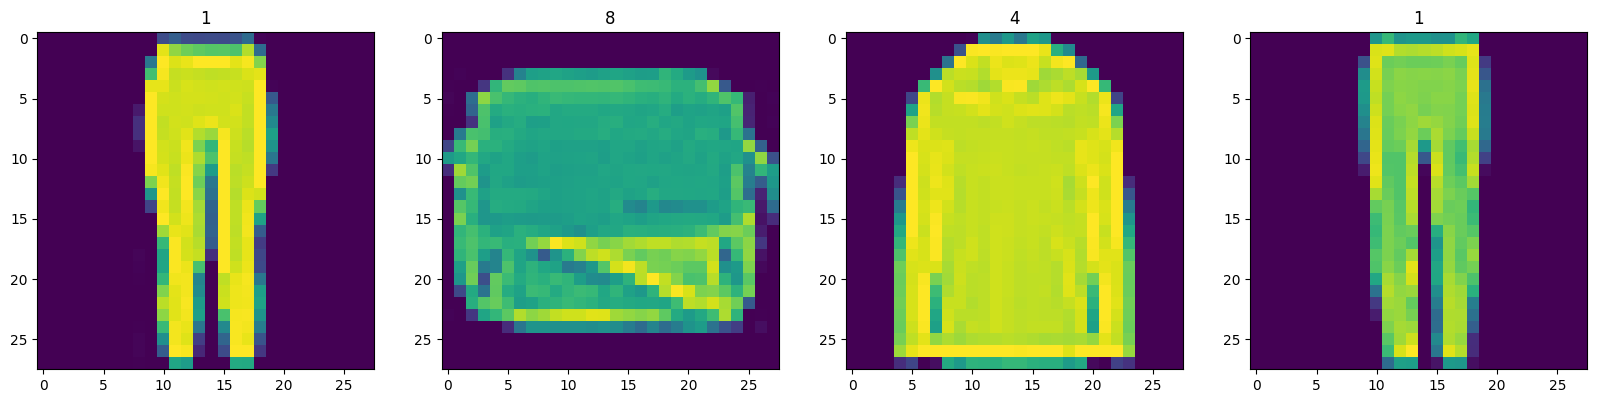

In [20]:
# visualizing some images
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for i in range(4):
    sample = dataiterator.next()
    ax[i].imshow(np.squeeze(sample['image']))
    ax[i].title.set_text(sample['label'])

# Preprocess image

In [21]:
def scale_img(data):
    return data['image']/255

In [22]:
ds = ds.map(scale_img)

# caches the ds to the memory 
ds = ds.cache()
ds = ds.shuffle(60000)

# creates and saves the data into batches of 128 
ds = ds.batch(128)

# prefetches some data to the memory asynchronously and preprocess in the background while the model is still working on the current batch to reduce training time and fully utilize the resources
ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [23]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# Build Neural Network

In [24]:
# Generator 
def build_generator():
    model = Sequential()
    
    # takes in random values of size 128 and outputs a 7x7x128 tensor
    # beginings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7,7,128)))
    
    # UpSampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=5, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # UpSampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=5, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # creating some more abstraction 
    model.add(Conv2D(128, kernel_size=4, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # more abstraction 
    model.add(Conv2D(128, kernel_size=4, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # final layer to get one channel image 
    model.add(Conv2D(1, kernel_size=4, padding='same', activation='sigmoid'))
    
    return model

generator = build_generator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

1/1 [==============================] - 0s 63ms/step
(28, 28, 1)


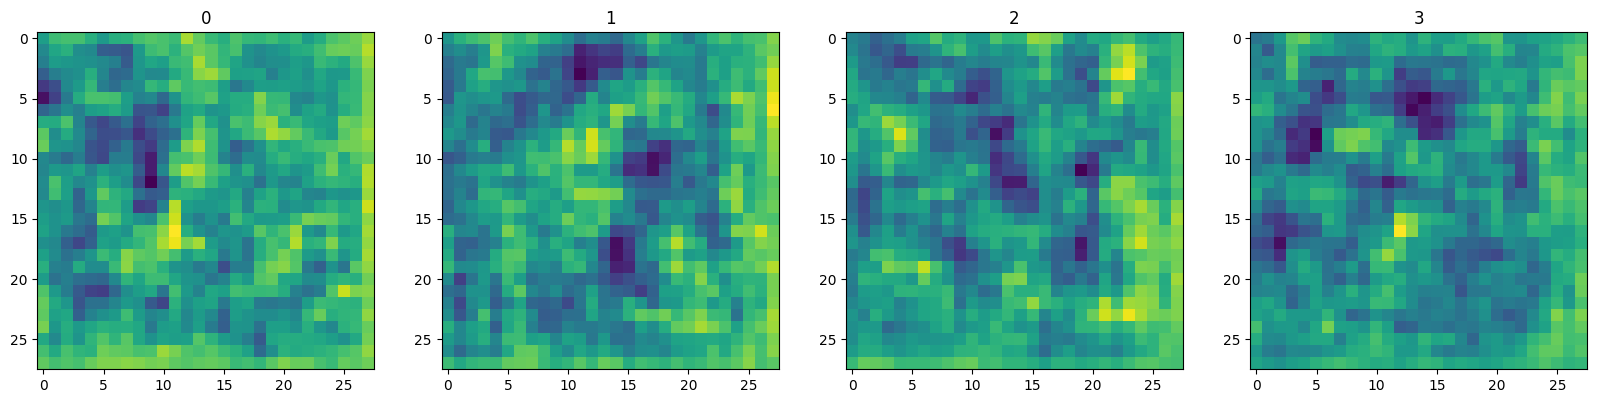

In [25]:
# predicting some random generated images and visualizing them 
imgs = generator.predict(np.random.randn(4,128,1))
print(imgs[0].shape)

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(imgs):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

In [26]:
# Discriminator 
def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=5, input_shape=(28,28,1)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(64, kernel_size=5))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128, kernel_size=5))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(256, kernel_size=5))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)      

In [27]:
# using discriminator to predict one of the generated images 
discriminator.predict(imgs[0].reshape(1,28,28,1))
# we reshape here because the discriminator expects a batch of images

1/1 [==============================] - 0s 55ms/step


array([[0.5141205]], dtype=float32)

# Custom Training Loop

In [28]:
# setup losses and oprimizers for both generator and discriminator 
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [29]:
# building the subclassed model using the base model
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs) #pass args and kwargs to the base class
        self.generator = generator
        self.discriminator = discriminator
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs) #pass args and kwargs to the base class
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
        
    def train_step(self, batch):
        # get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal(shape=(128,128,1)), training=False)
        
        # train the discriminator 
        with tf.GradientTape() as d_tape: #tf.GradientTape() is used to record the operations done on the tensors so that we can calculate the gradients later
            # pass the real and fake images to the discriminator model 
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # create labels for the real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # add some noise to the ouputs of the discriminator to make it more robust
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real)) #tf.random.uniform() takes in the shape of the tensor and returns a tensor of the same shape with random values between 0 and 1. and we multiply it by 0.15 to make the noise small
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # calculate the loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # apply backpropagation to update the discriminator weights
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) #calculates the gradients of the loss with respect to the trainable variables of the discriminator
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables)) #applies the gradients to the trainable variables of the discriminator for backpropagation
        
        # train the generator
        with tf.GradientTape() as g_tape:
            # generate some fake images
            fake_images = self.generator(tf.random.normal(shape=(128,128,1)), training=True)
            
            # pass the fake images to the discriminator
            yhat_fake = self.discriminator(fake_images, training=False)
            
            # calculate the loss
            total_g_loss = self.g_loss(tf.zeros_like(yhat_fake), yhat_fake)
        # apply backpropagation to update the generator weights
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {'d_loss': total_d_loss, 'g_loss': total_g_loss}
        

In [30]:
fashiongan = FashionGAN(generator, discriminator)
fashiongan.compile(g_opt, d_opt, g_loss, d_loss)

In [31]:
# callback
# this callback will be used to monitor the progress of the model and save 3 generated images after each epoch
class ModelMonitor(Callback):
    def __init__(self, num_img=1, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))
            


In [32]:
# train the model

hist = fashiongan.fit(ds, epochs=2000,callbacks=[ModelMonitor()])

Epoch 1/2000
469/469 [==============================] - 2407s 5s/step - d_loss: 0.5553 - g_loss: 0.8845
Epoch 2/2000
469/469 [==============================] - 2201s 5s/step - d_loss: 0.3506 - g_loss: 2.0804
Epoch 3/2000
469/469 [==============================] - 2096s 4s/step - d_loss: 0.2763 - g_loss: 2.6384
Epoch 4/2000
469/469 [==============================] - 2083s 4s/step - d_loss: 0.2746 - g_loss: 2.6654
Epoch 5/2000
469/469 [==============================] - 2090s 4s/step - d_loss: 0.4145 - g_loss: 2.0508
Epoch 6/2000
469/469 [==============================] - 2101s 4s/step - d_loss: 0.5922 - g_loss: 0.5433
Epoch 7/2000
469/469 [==============================] - 2108s 4s/step - d_loss: 0.4276 - g_loss: 0.1190
Epoch 8/2000
469/469 [==============================] - 2262s 5s/step - d_loss: 0.5370 - g_loss: 0.1579
Epoch 9/2000
469/469 [==============================] - 2230s 5s/step - d_loss: 0.7014 - g_loss: 0.6045
Epoch 10/2000
469/469 [==============================] - 2303s 5

KeyboardInterrupt: 

# Review Performance

In [ ]:
fashiongan.load_weights('model_weights_best.hdf5')


plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# Test out the generator

1/1 [==============================] - 0s 77ms/step


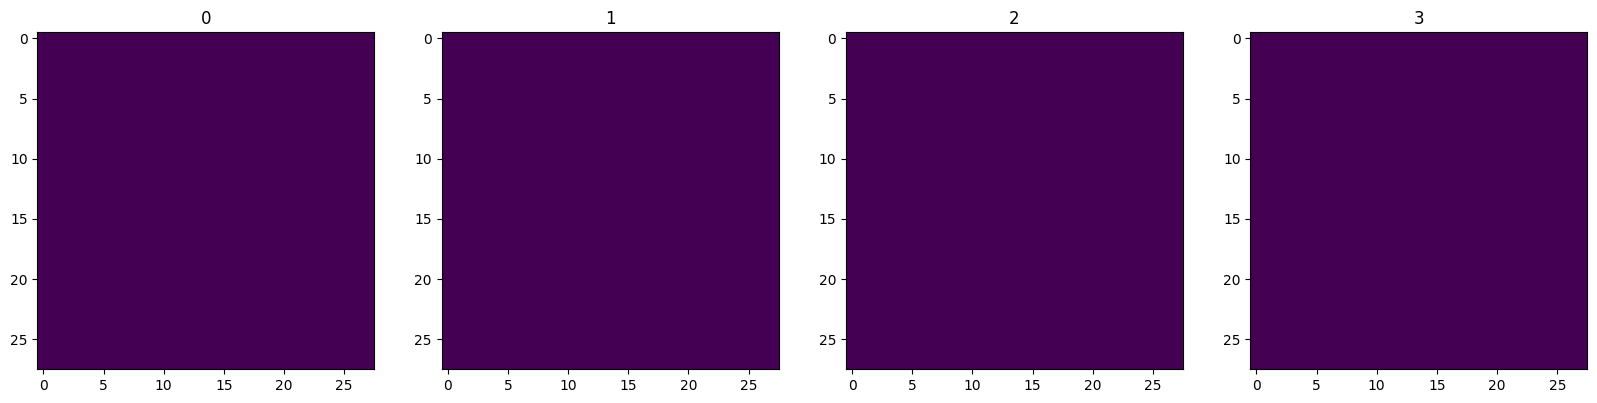

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])


# Save the models

In [ ]:
generator.save('generatormodel.h5')
discriminator.save('discriminatormodel.h5')